In [1]:
%load_ext autoreload
%autoreload 2
import bardensr
import IPython.display
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.spatial
import pandas as pd
import numpy.random as npr
import matplotlib.pylab as plt
%matplotlib inline
import tqdm.notebook
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'

```
Multiplexing (sometimes contracted to muxing) is a method 
by which multiple analog or digital signals are combined 
into one signal over a shared medium.

-- Wikipedia
```

The `bardensr` (barcode dexmixing through non-negative spatial regression) package is a collection of tools for modeling linearly multiplexed observations.  There is some true signal we are interested in, but our observations are some noisy linear mixture of those signals.  

`bardensr` currently contains only one module: `singlefov`.  This module was designed particularly for handling spatial transcriptomic problems on a single field of view.

# the singlefov module

In [3]:
bardensr.ipydoc(bardensr.singlefov,saynm=False,strip4=False)


This module is designed for handling an observation tensor $\mathbf{X}$ which has the following *properties*...

- **TENSOR STRUCTURE:** The observations can be understood as a tensor $\mathbf{X} \in \mathbb{R}^{M_1 \times M_2 \times M_3 \times R \times C}$.
- **NON-NEGATIVITY:** Each observation is non-negative (i.e. $\mathbf{X}_{m_1,m_2,m_3,r,c}\geq 0$)

... and which can be modeled using the following *parameters*...
- $\mathbf{B} \in \mathbb{R}^{R\times C\times J}$ is called the codebook
- $\rho \in \mathbb{R}^C$ is called the phasing parameter
- $\alpha \in \mathbb{R}^{R\times C}$ is called the gain
- $\varphi \in \mathbb{R}^{C\times C}$ is called the color-mixing
- $\mathbf{F} \in \mathbb{R}^{M_1 \times M_2 \times M_3 \times J}$ is called the density
- $\mathbf{K} \in \mathbb{R}^{M_1 \times M_2 \times M_3 \times M_1 \times M_2 \times M_3}$ is called the kernel, and it is assumed to be a 3-dimensional blur kernel.
- $a \in \mathbb{R}^{M_1 \times M_2 \times M_3}$ is called the spatial background
- $b \in \mathbb{R}^{R\times C}$ is called the frame background

... through the following *story*:

1. **PHASING:** The phasing parameter defines a tensor $\mathbf{Z}$ by letting $$\mathbf{Z}_{r,c,j} = \rho_c \mathbf{Z}_{r-1,c,j} + \mathbf{B}_{r,c,j}$$ for $r\geq 1$.  For $r=0$ we let $\mathbf{Z}_{0,c,j}=\mathbf{B}_{0,c,j}$.
1. **GAIN AND COLOR-MIXING** The gain and color-mixing parameters then give rise the tensor $$\mathbf{G}_{r,c,j} = \alpha_{r,c} \sum_{c'} \varphi_{c,c'}Z_{r,c',j}$$
1. **OBSERVATION MODEL** The observations $\mathbf{X}$ are approximately given by
$$\mathbf{X}_{m_1,m_2,m_3,r,c} \approx \sum_{m'_1=0}^{M_1-1}\sum_{m'_2=0}^{M_2-1}\sum_{m'_1=0}^{M_3-1} \sum_{j=0}^{J-1} \mathbf{G}_{r,c,j} \mathbf{F}_{m'_1,m'_2,m'_3, j} \mathbf{K}_{m_1,m_2,m_3,m'_1,m'_2,m'_3} + a_{m_1,m_2,m_3} + b_{r,c}$$

All the concepts above are described in more depth in the paper ((link forthcoming!)).


### What's in the box?

The singlefov has two functions:

- `simulate` -- this function simulates an example observation tensor $\mathbf{X}$ (according to the model above)
- `process` -- this function takes $\mathbf{X},\mathbf{B}$ (and several other optional parameters) as input, and tries to guess what $\mathbf{F}$ was (according to the model above)

In [4]:
bardensr.ipydoc(bardensr.singlefov.simulate)


 ### `simulate`

Simulates an observation tensor according to the singlefov model (described above).

Input:
- spatial_dims -- m1,m2,m3
- rolony_size -- magnitude of the blur kernel K
- n_rounds -- R
- n_channels -- C
- codebook -- see below
- genedistr -- when creating F, the number of nonzero entries in F
will be distributed so that $\sum_{m_1,m_2,m_3} F_{m_1,m_2,m_3,j} \propto \mathtt{genedistr}_j$
- n_rolonies -- number of nonzero entries in F
- required_hamdst -- see below
- noise -- magnitude of noise which causes observations to deviate from model
- scale_lo -- lowest magnitude of signal in F
- scale_hi -- highest magnitude of signal in F

Output: a dictionary with
- data: a M1 x M2 x M3 x R x C tensor
- ground_truth_densities: sparse representation of the nonzero entries in F
- codebook: the codebook B used to generate data

a word on the codebook.  this parameter can have one of two types:
1. if codebook == 'one-hot' it will make up a codebook with the right
number of rounds and channels.  it will require that all the codes are
at least required_hamdst different from each other, and it will assume
that the codebook is binary and (np.sum(codebook,1)==1).all().
2. if codebook is an array, R,C,required_hamdst will be ignored, and
we will just use the given codebook



In [5]:
# make a simulation
sim=bardensr.singlefov.simulate(
    spatial_dims=(200,200,1),
    n_barcodes=20,
    n_rolonies=4000,
    scale_lo=1,
    scale_hi=1.5,
    noise=.000001
)

In [6]:
# look at the positions of the the nonzero entries in the ground-truth F
pd.DataFrame(sim['ground_truth_positions'])

,m1,m2,m3,j,values
0,0,0,0,18,1.270521
1,0,1,0,18,1.346662
2,0,13,0,14,1.042159
3,0,18,0,7,1.342860
4,0,46,0,14,1.150945
...,...,...,...,...,...
3987,199,169,0,16,1.228363
3988,199,174,0,18,1.408963
3989,199,176,0,11,1.132106
3990,199,176,0,17,1.057468


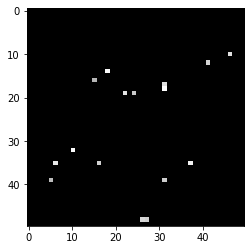

In [7]:
# because this dataset is small we can make a dense version of F 
# which is easier to manipulate
true_F=bardensr.singlefov.sparse2dense(**sim['ground_truth_positions'])

# let's look at some of  F

# look at F[m1,m2,m3,j]
# m1 in {0..49}
# m2 in {0..49}
# m3 = 0
# j = 0
plt.imshow(true_F[:50,:50,0,0])

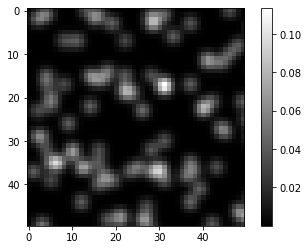

In [8]:
# look at some of the simulated data

# look at X[m1,m2,m3,r,c] for
# m1,m2 in {0....49}
# m3=0
# r=1
# c=2
plt.imshow(sim['data'][:50,:50,0,1,2])
plt.colorbar()

Text(0, 0.5, 'rounds')

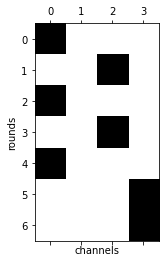

In [9]:
# look at the codebook

# let's look at B[r,c,j] for 
# j=0
# r in {0...R-1}
# c in {0...C-1}
plt.spy(sim['codebook'][:,:,0])
plt.xlabel("channels")
plt.ylabel("rounds")

In [10]:
bardensr.ipydoc(bardensr.singlefov.process)


 ### `process`

Given an observation tensor X and a codebook B, try to guess F.

Input:
- X
- B
- blur_level=3
- downsample_level=(10,10,2)
- tile_size=(200,200,10)
- phase_I_lambda=.01
- phase_I_initial_iterations=10
- phase_I_final_iterations=200
- phase_II_learn=()
- phase_II_lambda=.1
- phase_II_initial_iterations=10
- phase_II_final_iterations=200
- n_unused_barcodes=4
- unused_barcodes=None (or an array of shape (R, C, n_unused_barcodes))
- unused_barcode_threshold_multiplier=1.0
- unused_barcode_percentile_by_voxel=100
- unused_barcode_percentile_by_code=100
- tqdm_notebook=True

Output: a sparse representation of where rolony densities are significant
- values  -- each entry represents the estimated density present at a particular place --
- m1   -- these represent the relevant m1 location
- m2   -- these represent the relevant m2 location
- m3   -- these represent the relevant m3 location
- j -- these represent the relevant barcode
That is, for each i, we have that the density at position m1s[i],m2s[i],m3s[i]
corresponding to barcode bcds[i] has activity level vals[i].  The largest
barcode indices will correspond to the unused barcodes.

This algorithm proceeeds in two phases.
- Phase I.  Downsample and learn F,alpha,varphi,rho,a,b on downsampled data.  This learning
is an optimization process which uses phase_I_initial_iterations to get an initial guess for F
and then uses phase_I_final_iterations to optimize the other parameters.
- Phase II.  Break into tiles.  For each tile, unused barcodes give threshold
to discern codes which can be ignored.  Learn parameters with this reduced
set of codes for this tile, thereby learning F,a (and, optionally, alpha,varphi,rho,b).
For each tile, we use phase_II_initial_iterations and phase_II_final_iterations for
the learning process.  We then stitch tiles back together, store resulting F as a
sparse matrix.

A note on the "unused_barcodes."  We train the model in phase I and phase II as if
the unused barcodes were present in the data.  We then estimate the density F.  We then
compute the unused_barcode_threshold by
- computing the `unused_barcode_percentile_by_voxel` percentile of the density values
over voxels for each unused barcode
- computing the `unused_barcode_percentile_by_code` percentile over the resulting values
found for each unused barcode
- multiplying by `unused_barcode_threshold_multiplier`
We then use this threshold as a way to help guess where density activity is high
enough that it can be reliably understood.


In [16]:
rez=bardensr.singlefov.process(
    sim['data'],
    sim['codebook'],
    downsample_level=(10,10,1),
    tile_size=(50,50,1),
    blur_level=(3,3,0),
    unused_barcode_threshold_multiplier=1,
    phase_I_lambda=.00001,
    phase_II_lambda=.00001,
    tqdm_notebook=True,
    tqdm_notebook_bytile=False,
)

Phase I



Phase II


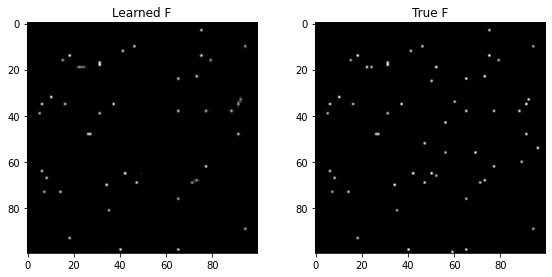

In [17]:
# compare the truth to what we learned
with bardensr.plotting.AnimAcross() as a:
    a('Learned F')
    F = bardensr.singlefov.sparse2dense(**rez)
    plt.imshow(F[0:100,:100,0,0])
    
    a("True F")
    true_F=bardensr.singlefov.sparse2dense(**sim['ground_truth_positions'])
    plt.imshow(true_F[:100,:100,0,0])